In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# import category_encoders as ce

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [53]:
sales = pd.read_csv('data/sales.csv')
forecast_data = pd.read_csv('data/REAL_DATA.csv', sep=';')

In [54]:
# Preprocessing
sales.date = pd.to_datetime(sales.date)
forecast_data.date = pd.to_datetime(forecast_data.date, format='%d/%m/%Y')

In [55]:
sales['year'] = sales.date.dt.year
sales['month'] = sales.date.dt.month
sales['day'] = sales.date.dt.day

forecast_data['year'] = forecast_data.date.dt.year
forecast_data['month'] = forecast_data.date.dt.month
forecast_data['day'] = forecast_data.date.dt.day


In [56]:
sales = sales.sort_values(by='date')
forecast_data = forecast_data.sort_values(by='date')

In [57]:
sales=sales.drop(columns=[sales.columns[0]], axis=1)
forecast_data=forecast_data.drop(columns=['index'], axis=1)

In [58]:
# one hot encoding to state_holiday
sales = pd.get_dummies(sales, columns=['state_holiday'])
forecast_data = pd.get_dummies(forecast_data, columns=['state_holiday'])


# category encoding
# encoder = ce.TargetEncoder(cols=['store_ID'])
mean_target_per_store = sales.groupby('store_ID')['sales'].mean()

# Map the mean target values to the 'store_ID' column in both DataFrames
sales['store_ID'] = sales['store_ID'].map(mean_target_per_store)
forecast_data['store_ID'] = forecast_data['store_ID'].map(mean_target_per_store)


In [59]:
X_train = sales[sales.year < 2015].drop(columns=['sales', 'date'],axis=1)
y_train = sales[sales.year < 2015].sales

X_test = sales[sales.year >= 2015].drop(columns=['sales', 'date'],axis=1)
y_test = sales[sales.year >= 2015].sales

X_train.head()

,store_ID,day_of_week,nb_customers_on_day,open,promotion,school_holiday,year,month,day,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
296090,5858.665574,2,0,0,0,1,2013,1,1,False,True,False,False
520181,8315.564626,2,0,0,0,1,2013,1,1,False,True,False,False
183479,6218.496644,2,0,0,0,1,2013,1,1,False,True,False,False
360138,4585.347899,2,0,0,0,1,2013,1,1,False,True,False,False
302547,6951.964103,2,0,0,0,1,2013,1,1,False,True,False,False


In [64]:
# Model training
model = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds=50)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

print(model)

[0]	validation_0-rmse:2845.95548	validation_1-rmse:2848.02451
[100]	validation_0-rmse:779.26684	validation_1-rmse:932.62366
[200]	validation_0-rmse:731.39949	validation_1-rmse:920.74423
[300]	validation_0-rmse:704.78873	validation_1-rmse:915.81022
[306]	validation_0-rmse:703.64770	validation_1-rmse:915.70870
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
      

In [65]:
y_pred = model.predict(X_test)

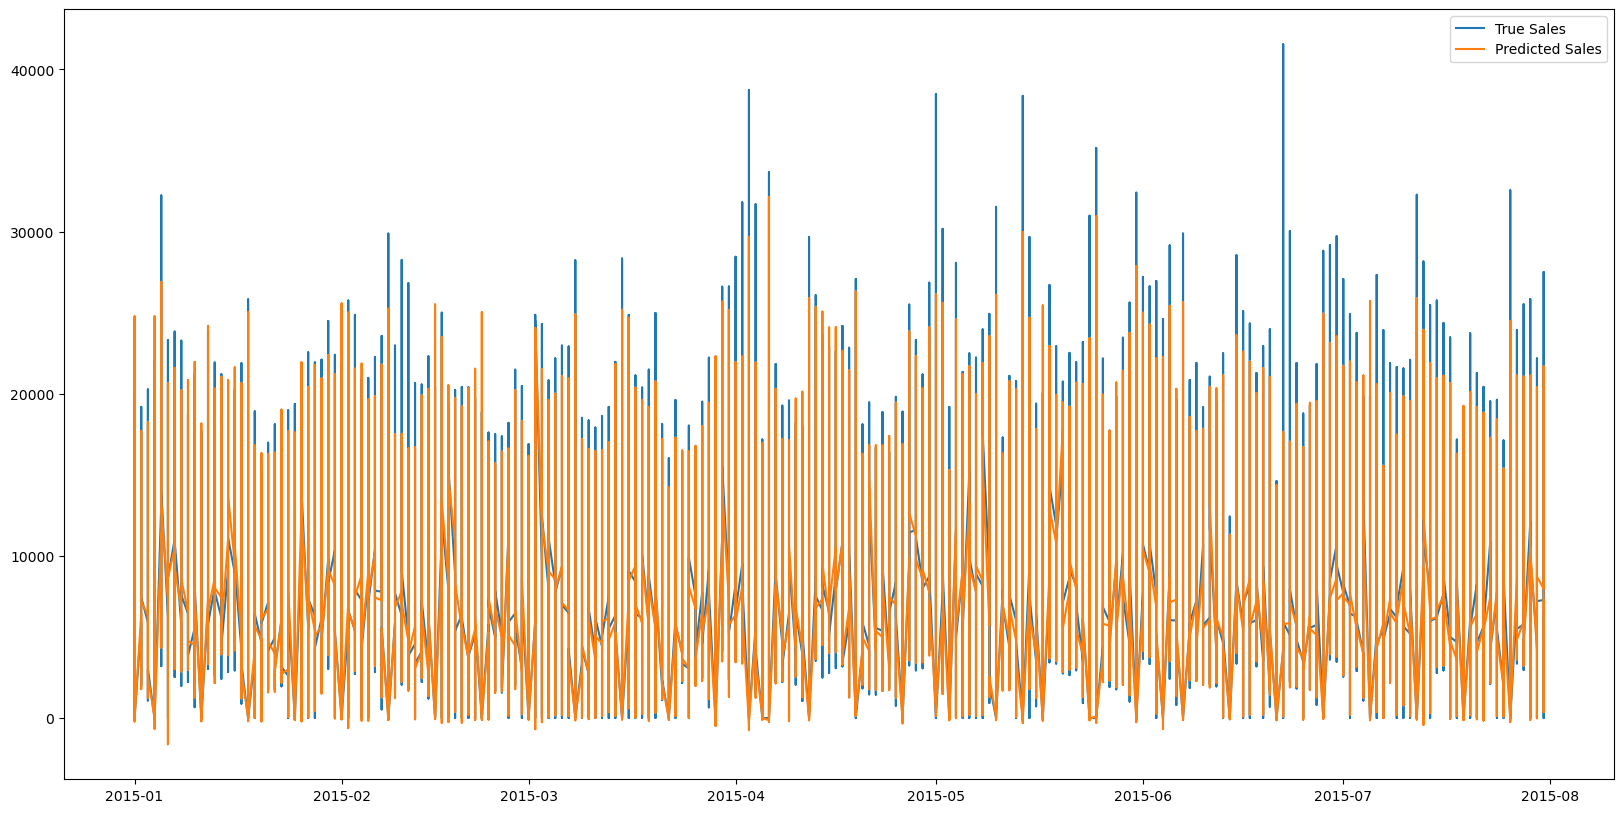

In [74]:
#plot y_test and y_pred. the X axis is the date
plt.figure(figsize=(20,10))
plt.plot(sales[sales.year >= 2015].date, y_test, label='True Sales')
plt.plot(sales[sales.year >= 2015].date, y_pred, label='Predicted Sales')
plt.legend()
plt.show()

In [69]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'R2: {r2}')
print(f'RMSE: {rmse}')

R2: 0.9432980418205261
RMSE: 914.2778912890763
